In [ ]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt
import warnings

 
warnings.filterwarnings("ignore")
plt.rc('font', family='NanumBarunGothic') 

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **DATA cleansing**

In [ ]:
all = pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/all_clean.csv',parse_dates=['STD_YMD'])

In [ ]:
cj = list(all.filter(like='CJ').columns)
gs = list(all.filter(like='GS').columns)
tmst = list(all.filter(like='TMST').columns)
sc = all.drop(cj+gs+tmst, axis = 1) 
amt = list(sc.filter(like='AMT').columns)
sc_cnt = sc.drop(amt,axis=1)
sc_cnt = sc_cnt.query('HDONG_GU =="서울 중구" or HDONG_GU == "서울 노원구"')

In [ ]:
sc_cnt_sum = sc_cnt.groupby('STD_YMD').sum().reset_index()
sc_cnt_sum.columns.values[1:] = list(map(lambda x : x[7:],sc_cnt_sum.columns.values[1:]))

In [ ]:
sc_cnt_sum_19 =sc_cnt_sum[sc_cnt_sum['STD_YMD'] < '2020']
sc_cnt_sum_20 =sc_cnt_sum[sc_cnt_sum['STD_YMD'] > '2020']

sc_cnt_sum_20.index = sc_cnt_sum_20['STD_YMD']
del sc_cnt_sum_20['STD_YMD']

In [ ]:
#correlation heatmap
#plt.figure(figsize=(10,10))
#sns.heatmap(data = sc_cnt_sum_20.corr(method='spearman'), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
#plt.show()

# **2020 clustering**

In [ ]:
sc_cnt_sum_20_roll3 = pd.DataFrame(sc_cnt_sum_20.rolling(3).mean())
sc_cnt_sum_20_roll5 = pd.DataFrame(sc_cnt_sum_20.rolling(5).mean())
sc_cnt_sum_20_roll7 = pd.DataFrame(sc_cnt_sum_20.rolling(7).mean())

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import scipy.cluster.hierarchy as hac
from scipy import stats
from scipy.cluster.hierarchy import cut_tree

def hclust(data,metric):
  min_max_scaler = MinMaxScaler()
  data_scaled = min_max_scaler.fit_transform(np.array(data))

  data_scaled= pd.DataFrame(data_scaled)
  data_scaled.columns = data.columns
  data_scaled = data_scaled.T

  # Do the clustering
  Z = hac.linkage(data_scaled, method='single', metric=metric)
  
  # Plot dendogram
  plt.figure(figsize=(8, 6))
  plt.title('Hierarchical Clustering Dendrogram',fontsize=20)
  plt.xlabel('sample index')
  plt.ylabel('distance')
  hac.dendrogram(
      Z,
      leaf_rotation=90.,  # rotates the x axis labels
      leaf_font_size=8.,  # font size for the x axis labels
  )
  plt.show()

  return(Z)

## **clustering (method = DTW)**

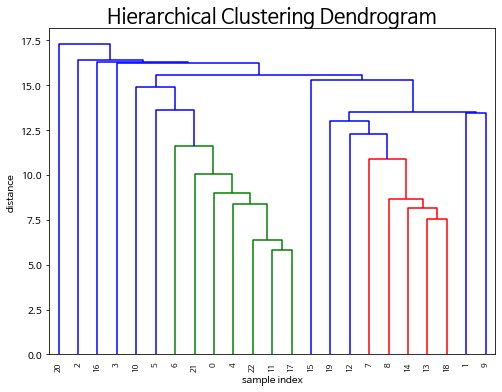

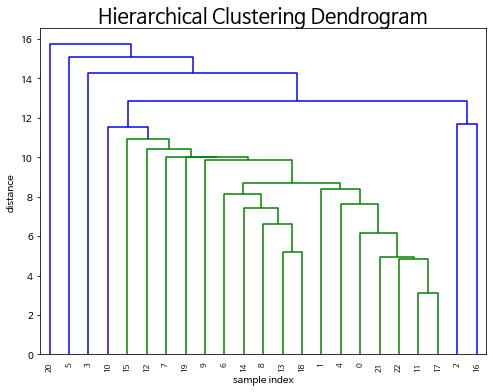

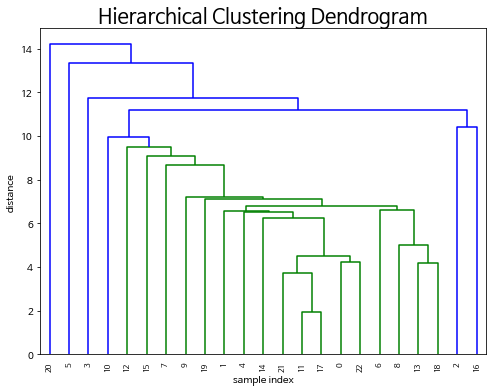

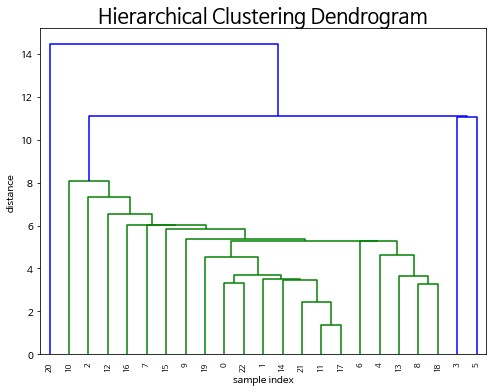

In [ ]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

def dtw(x, y):
    d = fastdtw(x, y, dist=euclidean)[0]
    return d 
    
DTW = hclust(sc_cnt_sum_20.dropna(),dtw) # 최종 선택 후, cut tree 진행
DTW_roll3 = hclust(sc_cnt_sum_20_roll3.dropna(),dtw)
DTW_roll5 = hclust(sc_cnt_sum_20_roll5.dropna(),dtw)
DTW_roll7 = hclust(sc_cnt_sum_20_roll7.dropna(),dtw)

In [ ]:
DTW_info = cut_tree(DTW,13)
DTW_info_roll3 = cut_tree(DTW_roll3, 7)
DTW_info_roll5 = cut_tree(DTW_roll5, 5)
DTW_info_roll7 = cut_tree(DTW_roll7, 3)

In [ ]:
#pearson_info = pearson_info.reshape(-1,)
#pearson_info_roll3 = pearson_info_roll3.reshape(-1,)
#pearson_info_roll5 = pearson_info_roll5.reshape(-1,)

DTW_info=DTW_info.reshape(-1,)
DTW_info_roll3=DTW_info_roll3.reshape(-1,)
DTW_info_roll5=DTW_info_roll5.reshape(-1,)
DTW_info_roll7=DTW_info_roll7.reshape(-1,)

In [ ]:
cat = np.array(sc_cnt_sum_20.columns)

In [ ]:
cluster_result = pd.DataFrame({'업종':cat,
                              #'pearson':pearson_info,
                              #'pearson_roll3':pearson_info_roll3,
                              #'pearson_roll5':pearson_info_roll5,
                               'DTW':DTW_info,
                               'DTW_roll3':DTW_info_roll3,
                               'DTW_roll5':DTW_info_roll5,
                               'DTW_roll7':DTW_info_roll7})
cluster_result

## **DTW cluster graph**

In [ ]:
#data scaling
def scaler(data):
  min_max_scaler = MinMaxScaler()
  data_scaled = min_max_scaler.fit_transform(np.array(data))

  data_scaled= pd.DataFrame(data_scaled)
  data_scaled.columns = data.columns
  return data_scaled

# kind show
def clustering_plot(cluster,data):
  
  dat = scaler(data)


  legend1 = []
  title=""
  plt.figure(figsize=(6,6))
  for i in range(0, len(cluster)):
      plt.plot(dat.loc[:,cluster[i]], linewidth=1,markersize=5)
      legend1.append(cluster[i])
      if len(cluster) == 1:
        title = cluster[i]
      else:
        title = title + cluster[i] + ', '


  plt.title(title, fontsize=20)
  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off

  plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off

  plt.yticks(color='w')
  legend1=[x[7:] for x in legend1]
  #plt.legend(legend1,bbox_to_anchor=(1,0.5),loc='center left',fontsize=10)
  #plt.legend(legend1,loc='lower center',bbox_to_anchor=(0.5, 0.9),ncol=len(legend1)-1,fontsize=8)

  plt.show()

### 1.**DTW no rolling (실제 사용한 방법)**

In [ ]:
n=cluster_result['DTW'].max()+1
for i in range(n):
  cluster = list(cluster_result.loc[cluster_result['DTW'] == i].업종)
  clustering_plot(cluster,sc_cnt_sum_20)

### **2. DTW rolling 3**

In [ ]:
n=cluster_result['DTW_roll3'].max()+1
for i in range(n):
  cluster = list(cluster_result.loc[cluster_result['DTW_roll3'] == i].업종)
  clustering_plot(cluster,sc_cnt_sum_20_roll3)

### **3. DTW rolling 5**

In [ ]:
n=cluster_result['DTW_roll5'].max()+1
for i in range(n):
  cluster = list(cluster_result.loc[cluster_result['DTW_roll5'] == i].업종)
  clustering_plot(cluster,sc_cnt_sum_20_roll5)

### **4. DTW rolling 7**

In [ ]:
n=cluster_result['DTW_roll7'].max()+1
for i in range(n):
  cluster = list(cluster_result.loc[cluster_result['DTW_roll7'] == i].업종)
  clustering_plot(cluster,sc_cnt_sum_20_roll7)

# **동별 업종 건수 summary**

In [ ]:
sc_cnt_dong= sc_cnt.groupby(['HDONG_NM']).sum()

위에 표에서 확인할 수 있듯, 지역에 해당업종이 존재하지 않는 경우들이 있어 데이터 bias를 일으킬 수 있음.

In [ ]:
sc_cnt_dong.loc[:,(sc_cnt_dong==0).any(axis=0)].describe()